In [1]:
import re

BIODIVERSITY_PATTERN = re.compile(r"biodiversity of (\d+) unique species")
STDOUT_FILE_PATTERN = re.compile(r"stdout_([^_]+)_([^_]+)_([^_]+)_([^_]+)_([^_]+)_([^_]+)_([^_]+)_([^_]+)_(.+)\.txt")

In [2]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import os
from collections import defaultdict
from pathlib import Path
import scipy.special as sp
from itertools import product
from scipy.stats import norm

In [3]:
def preston(A_on_sigma_sq, nu):
    a = np.sqrt(A_on_sigma_sq / np.pi)
    
    nu_eff = nu * np.log(1.0 / nu) / (1.0 - nu)
    
    num = 2.0 * np.pi * a * (1.0 - nu_eff) * sp.i1e(a)
    
    denom = (1.0 / np.sqrt(nu_eff)) * sp.i1e(a) * sp.k0e(np.sqrt(nu_eff) * a) / sp.k1e(np.sqrt(nu_eff) * a) + sp.i0e(a)
    
    return (nu_eff * A_on_sigma_sq + num / denom)

def s_contig(A_eff, deme, nu, sigma_sq):
    return sigma_sq * preston(A_eff * deme / sigma_sq, nu)

def s_island(A_eff, deme, nu):
    theta_A_eff = (deme * A_eff - 1.0) * nu / (1.0 - nu)
    
    return theta_A_eff * (sp.digamma(theta_A_eff + deme * A_eff) - sp.digamma(theta_A_eff))

def s_island_limit(A_eff, deme, nu):
    return ((A_eff * deme - 1.0) * nu * np.log(1.0 / nu)) / (1.0 - nu)

def s_migration(A_eff_local, deme_local, A_eff_meta, deme_meta, my_local, nu_meta):
    J = A_eff_local * deme_local
    J_m = A_eff_meta * deme_meta
    
    theta = (J_m - 1) * nu_meta / (1.0 - nu_meta)
    lamda = (J - 1) * my_local / (1.0 - my_local)
    
    return theta * (sp.digamma(theta + lamda * (sp.digamma(lamda + J) - sp.digamma(lamda))) - sp.digamma(theta))

def s_migration_limit(A_eff_local, deme_local, A_eff_meta, deme_meta, my_local, nu_meta):
    J = A_eff_local * deme_local
    J_m = A_eff_meta * deme_meta
    
    theta = (J_m - 1) * nu_meta / (1.0 - nu_meta)
    lamda = (J - 1) * my_local / (1.0 - my_local)
    
    return theta * np.log(1.0 - (lamda / theta) * np.log(my_local))

def s_always_migration(A_eff_local, deme_local, A_eff_meta, deme_meta, nu_meta):
    J = A_eff_local * deme_local
    J_m = A_eff_meta * deme_meta
    
    theta = (J_m - 1) * nu_meta / (1.0 - nu_meta)
    
    return theta * np.log(1 + (J - 1) / theta)

In [4]:
biodiversities = defaultdict(dict)

for root, dirs, files in os.walk("output"):
    root = Path(root)
    
    for file in files:
        match = STDOUT_FILE_PATTERN.match(file)
        
        if match is None:
            continue
        
        algorithm = match.group(1)
        seed = int(match.group(2))
        migration = float(match.group(3))
        meta_spec = float(match.group(4))
        sample = float(match.group(5))
        local_area = int(match.group(6))
        local_deme = int(match.group(7))
        meta_area = int(match.group(8))
        meta_deme = int(match.group(9))
        
        with open(root / file, 'r') as file:
            biodiversities[(algorithm, migration, meta_spec, sample, local_area, local_deme, meta_area, meta_deme)][seed] = int(BIODIVERSITY_PATTERN.search(file.read()).group(1))
    
    break

biodiversities = dict(sorted(biodiversities.items(), key=lambda kv: kv[0][::-1]))

In [5]:
biodiversitiesv2 = defaultdict(dict)

for root, dirs, files in os.walk("outputv2"):
    root = Path(root)
    
    for file in files:
        match = STDOUT_FILE_PATTERN.match(file)
        
        if match is None:
            continue
        
        algorithm = match.group(1)
        seed = int(match.group(2))
        migration = float(match.group(3))
        meta_spec = float(match.group(4))
        sample = float(match.group(5))
        local_area = int(match.group(6))
        local_deme = int(match.group(7))
        meta_area = int(match.group(8))
        meta_deme = int(match.group(9))
        
        with open(root / file, 'r') as file:
            biodiversitiesv2[(algorithm, migration, meta_spec, sample, local_area, local_deme, meta_area, meta_deme)][seed] = int(BIODIVERSITY_PATTERN.search(file.read()).group(1))
    
    break

biodiversitiesv2 = dict(sorted(biodiversitiesv2.items(), key=lambda kv: kv[0][::-1]))

In [6]:
def confidenceInterval(a, conf=0.95):
    mean = np.mean(a)
    sem = stats.sem(a)
    
    t = stats.t.ppf((1.0 + conf) * 0.5, len(a) - 1)
    
    return mean - t*sem, mean + t*sem

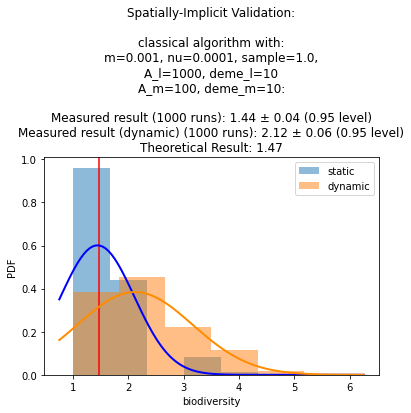

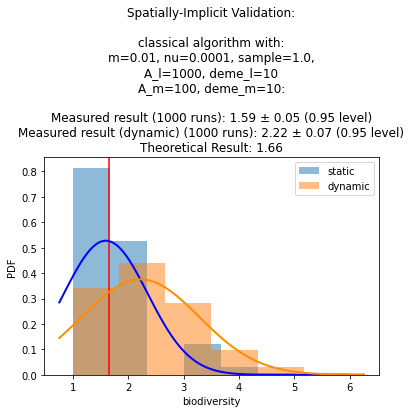

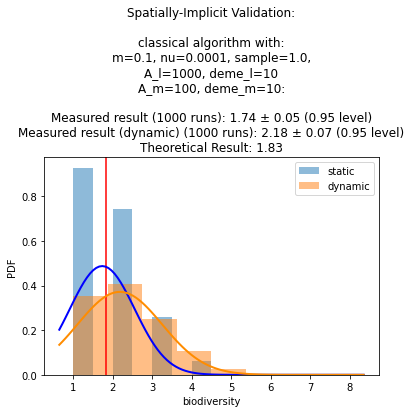

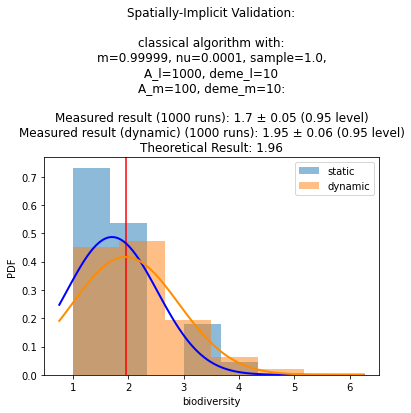

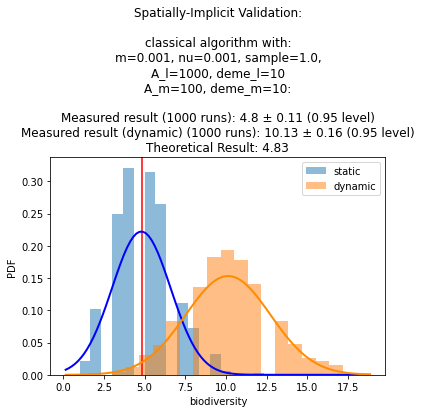

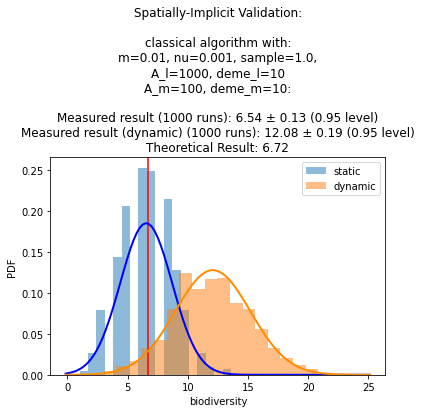

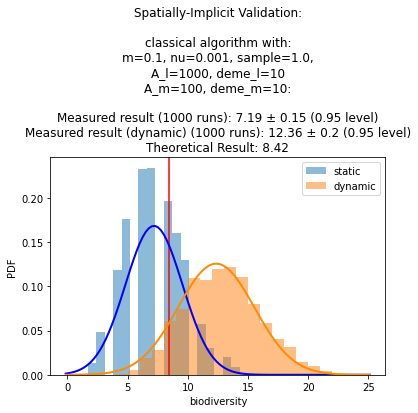

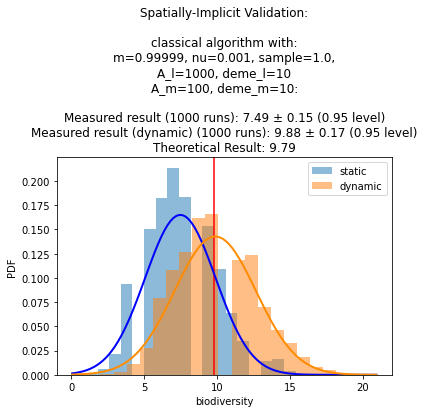

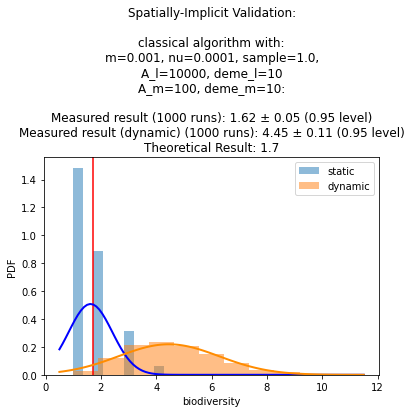

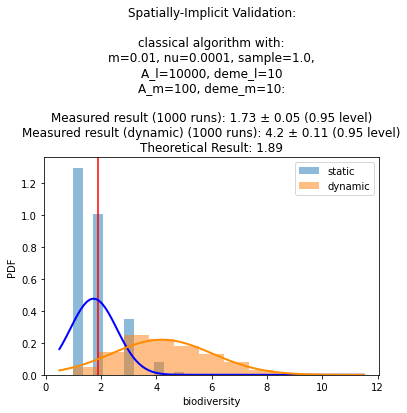

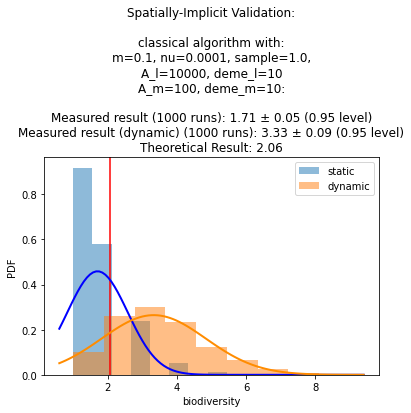

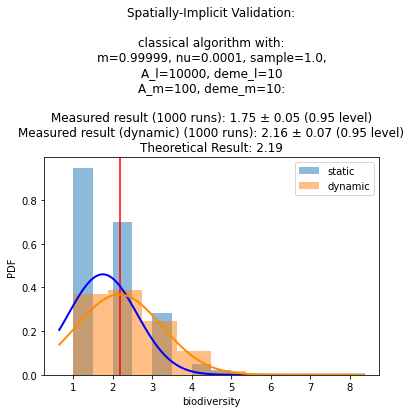

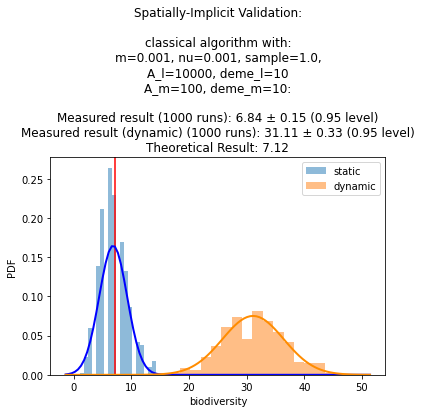

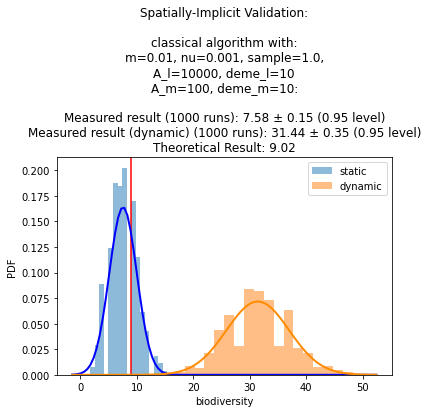

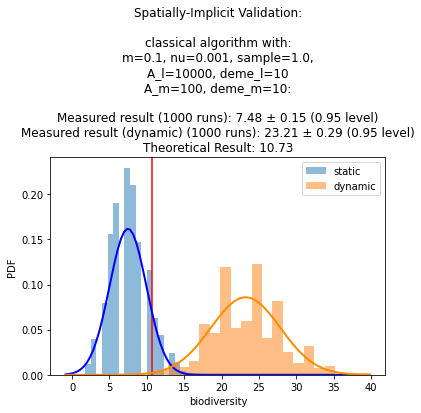

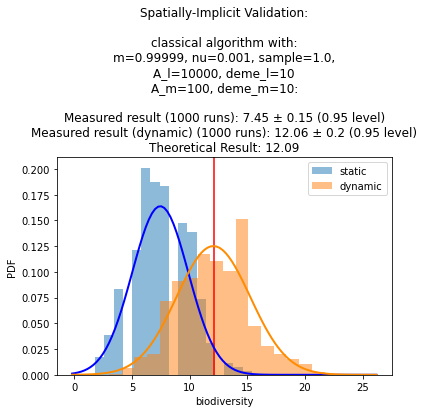

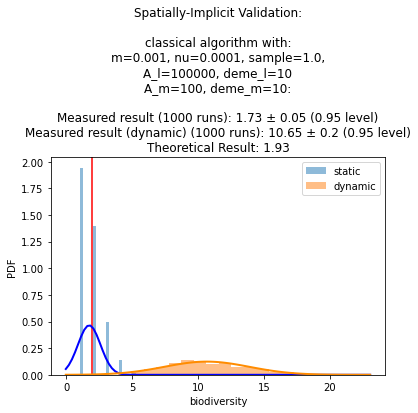

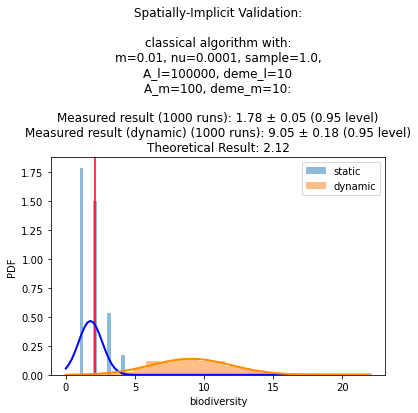

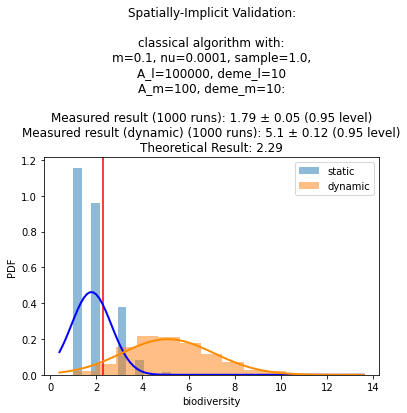

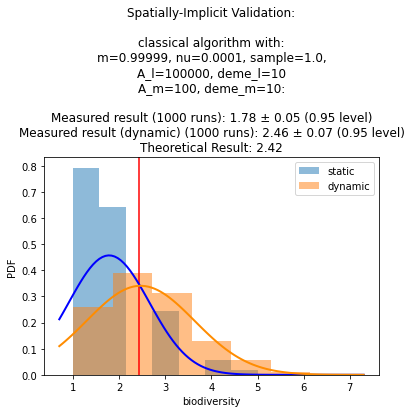

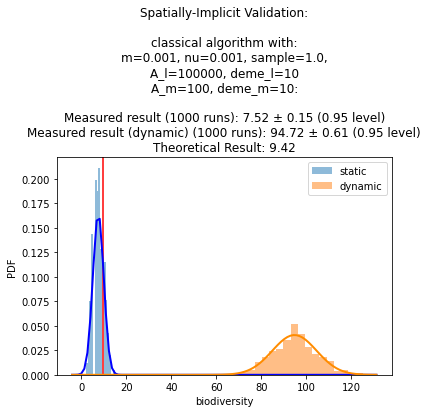

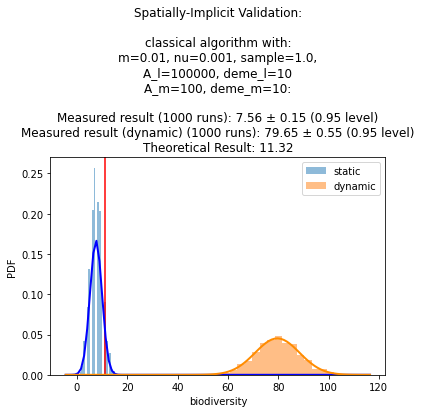

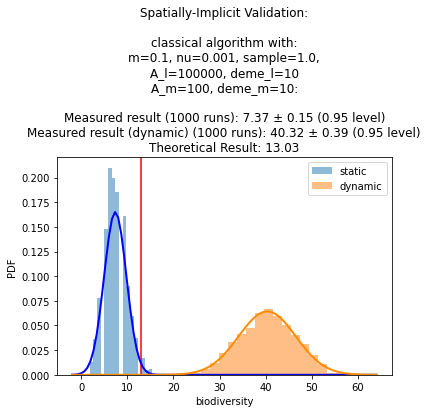

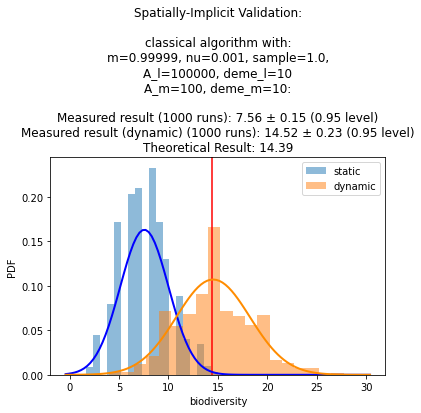

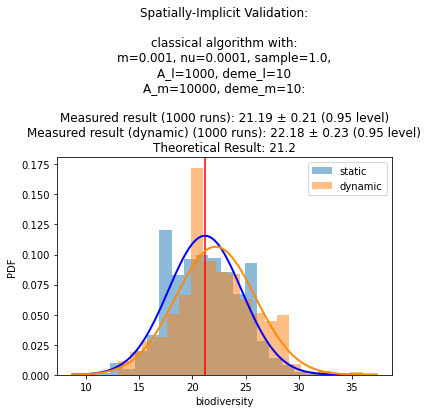

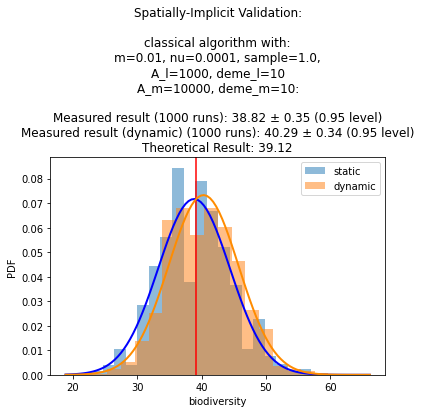

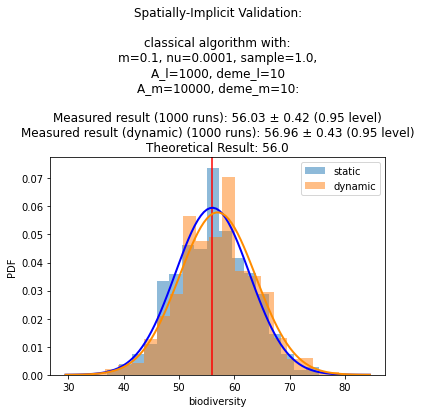

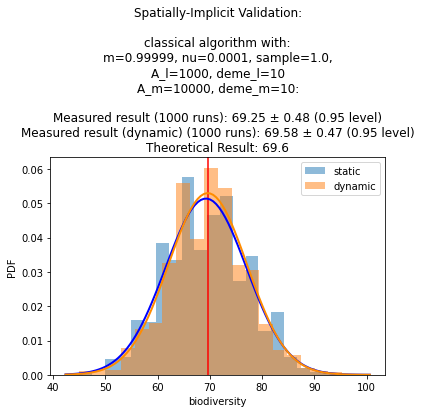

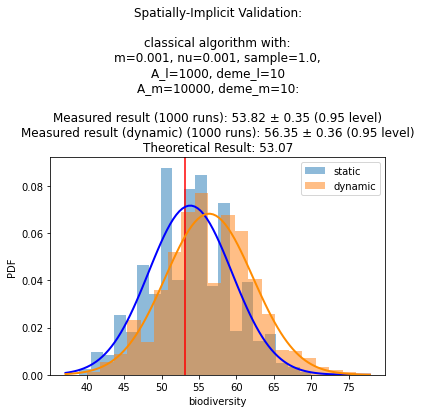

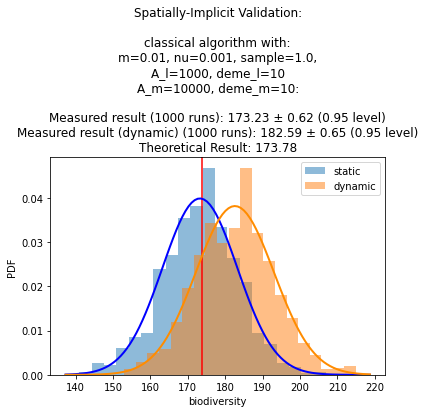

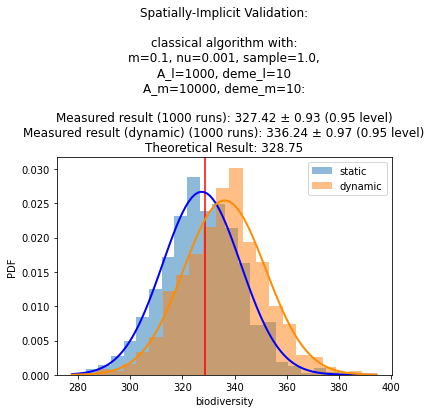

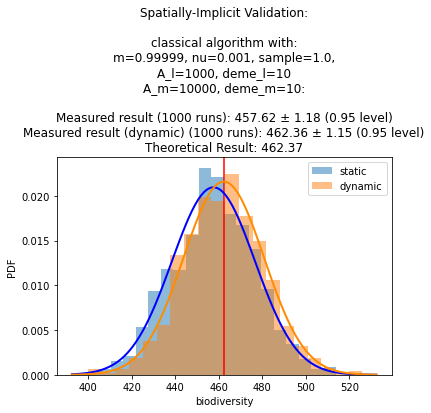

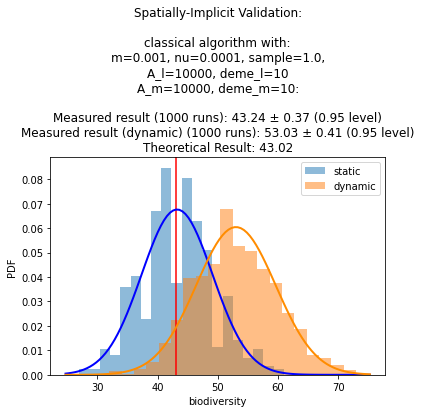

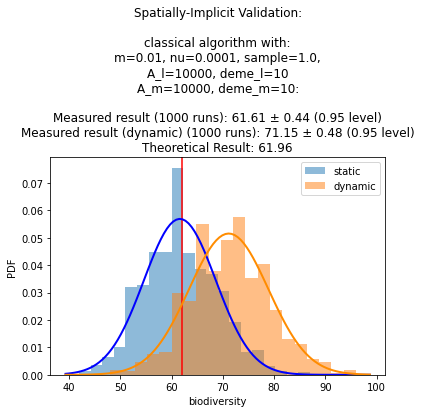

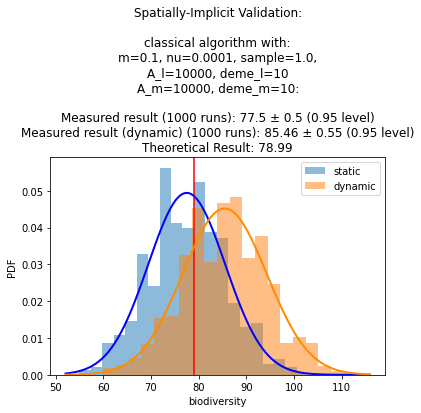

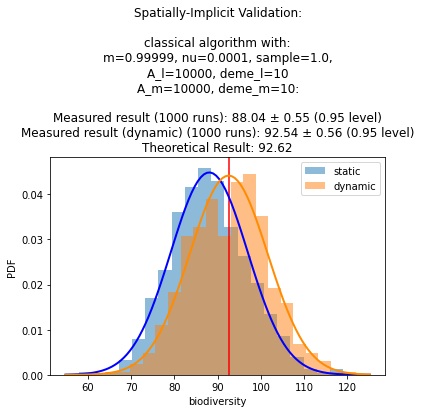

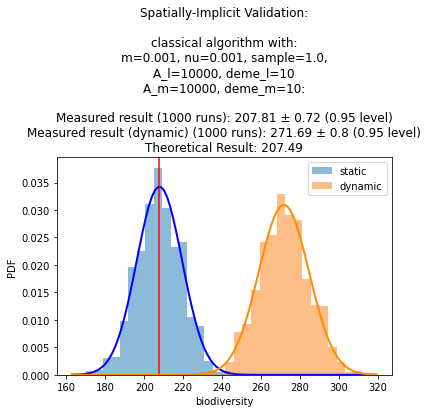

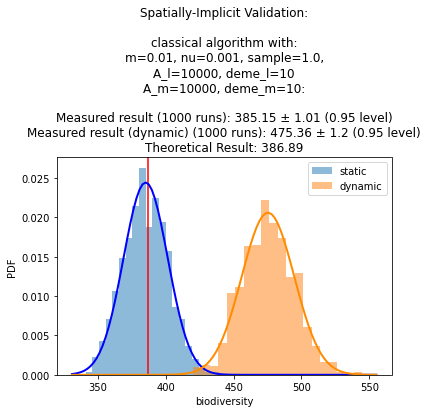

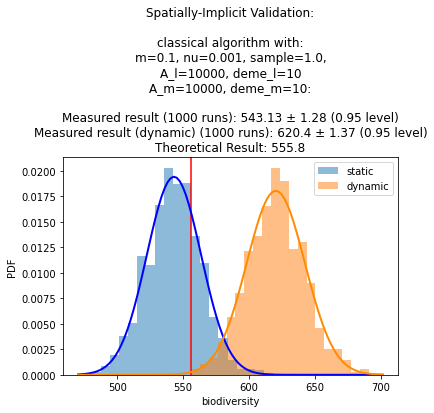

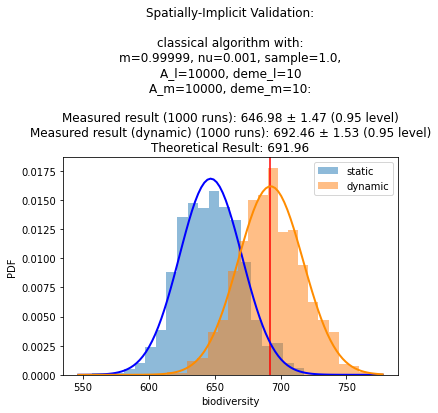

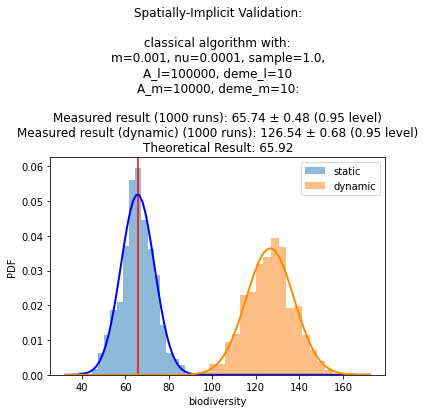

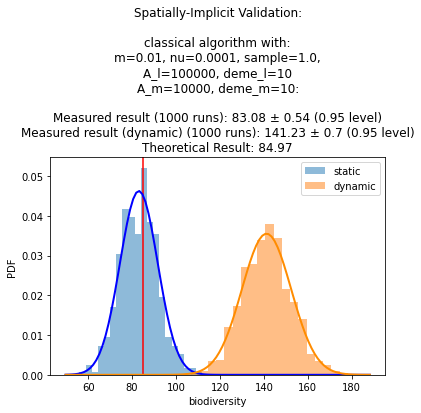

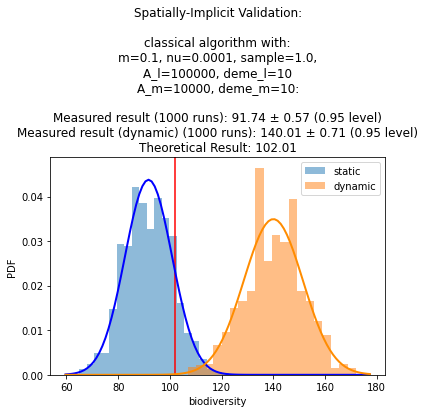

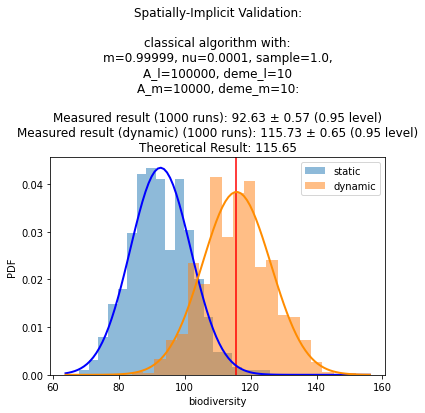

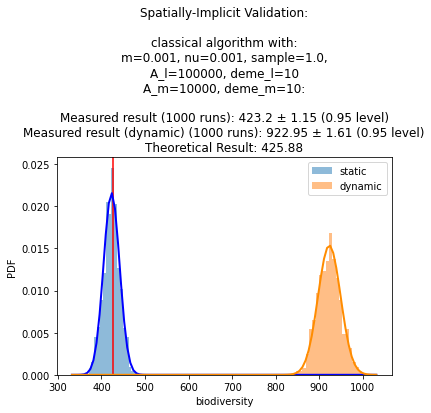

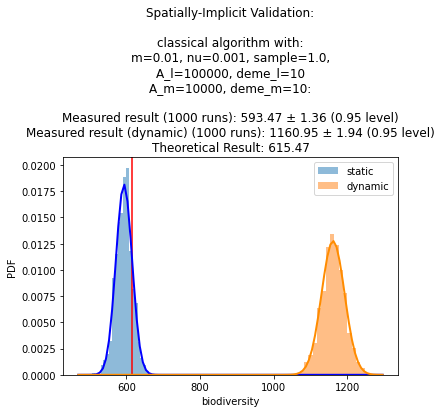

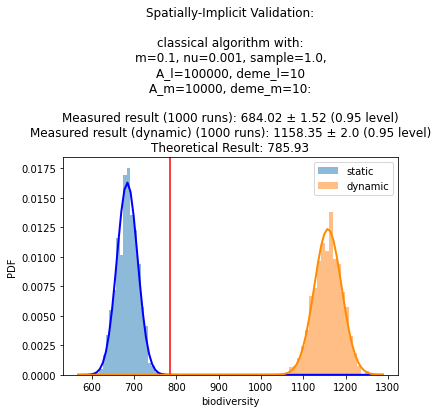

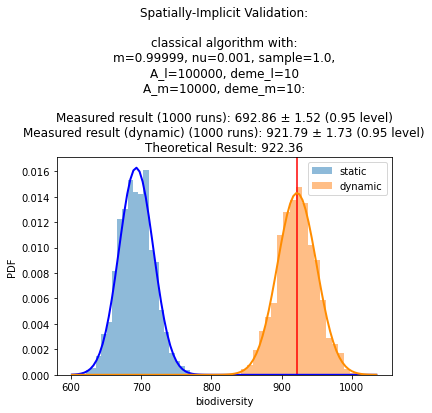

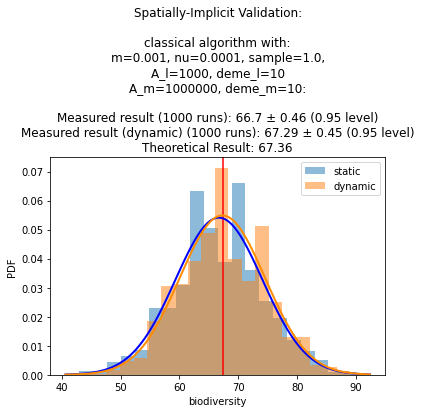

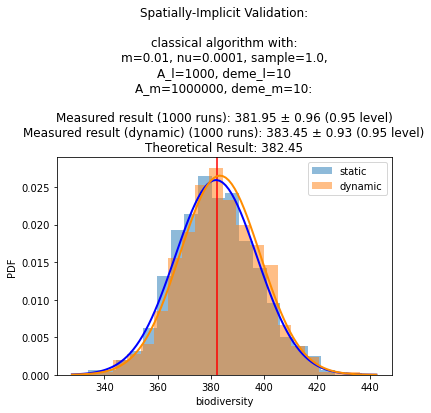

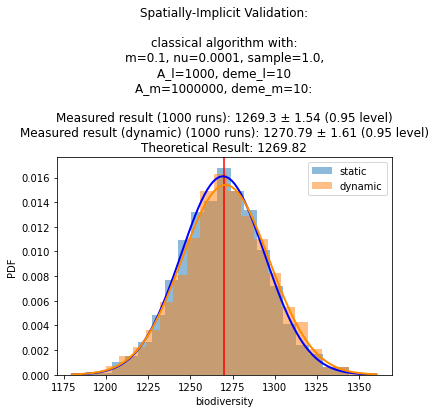

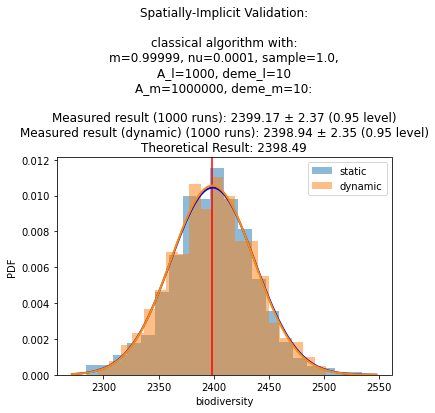

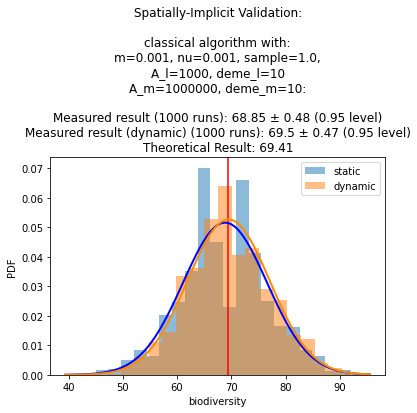

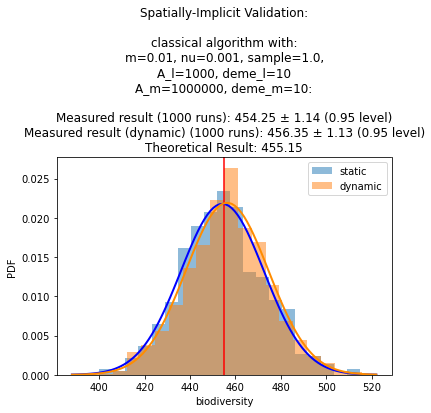

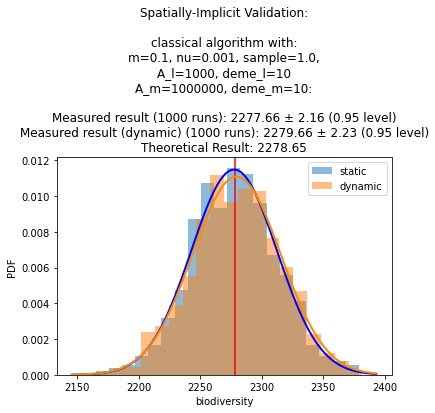

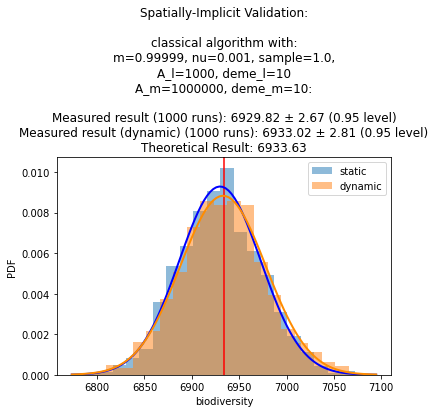

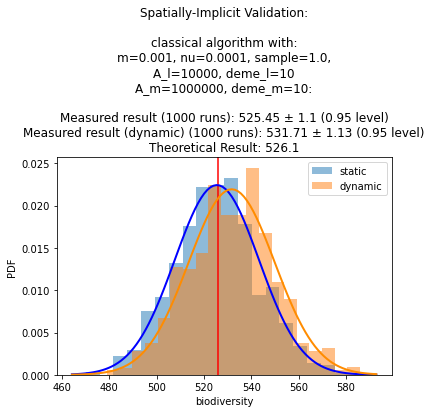

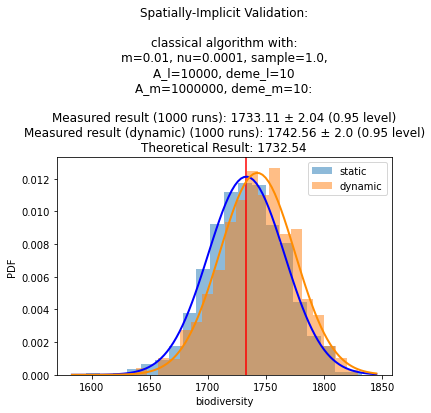

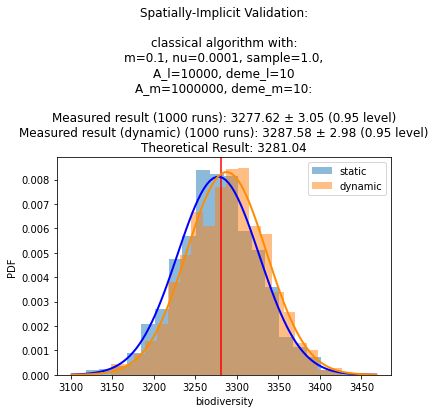

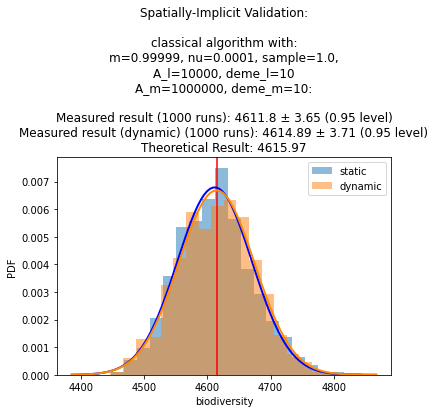

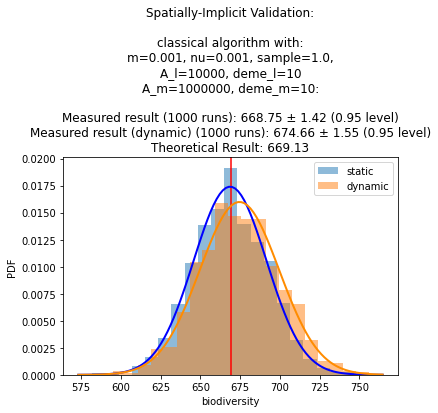

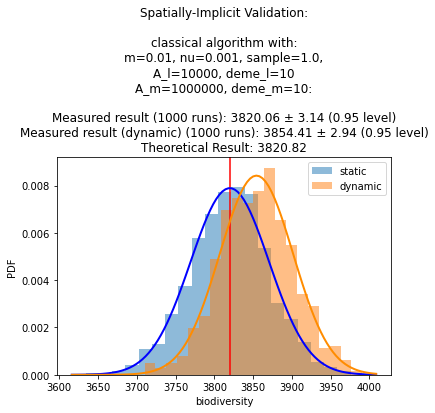

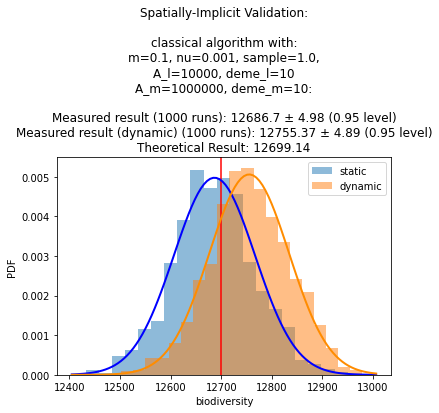

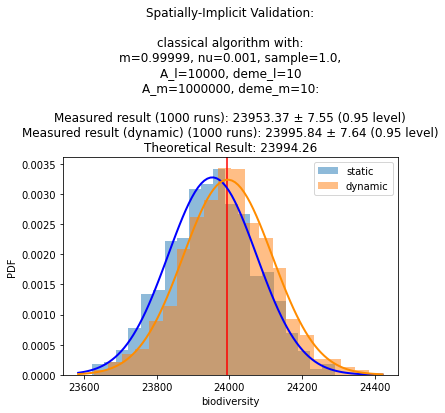

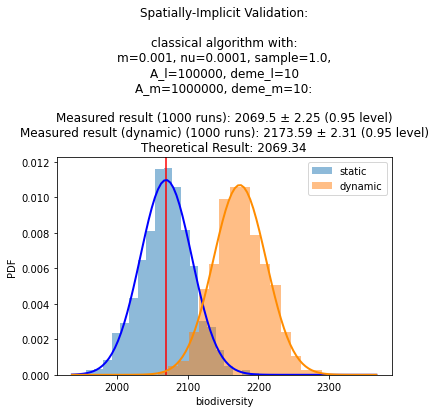

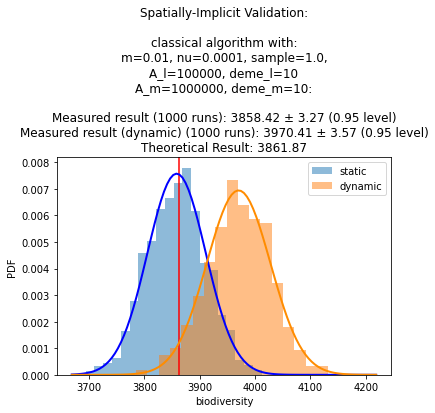

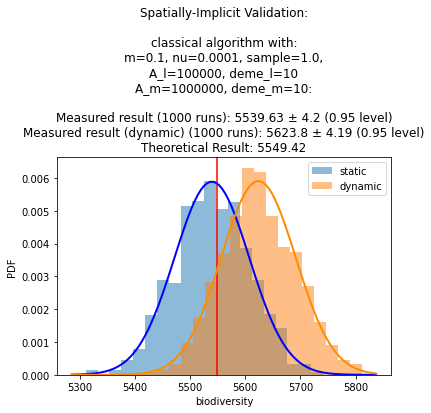

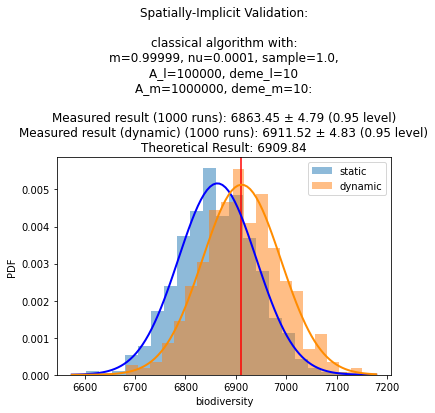

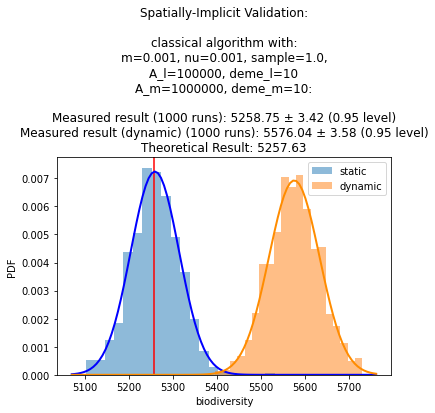

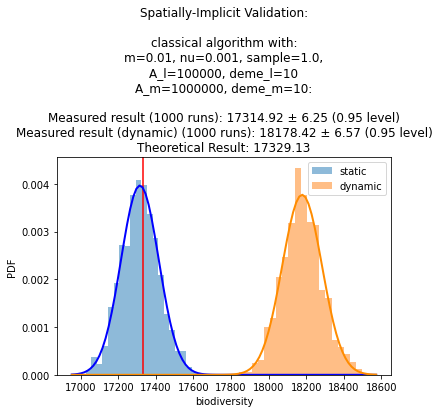

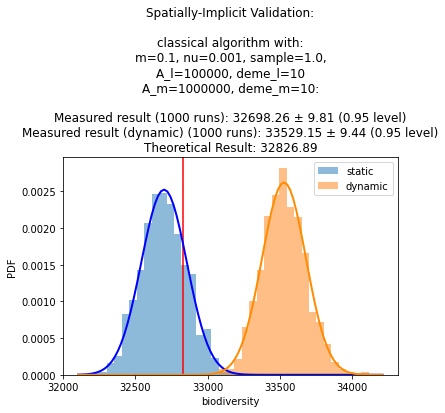

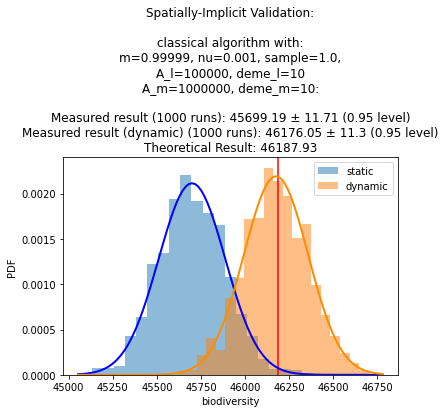

In [7]:
conf = 0.95

for key, values in biodiversities.items():
    values = tuple(values.values())
    valuesv2 = tuple(biodiversitiesv2[key].values())
    
    low, high = confidenceInterval(values)
    lowv2, highv2 = confidenceInterval(valuesv2)
    
    algorithm, migration, meta_spec, sample, local_area, local_deme, meta_area, meta_deme = key
    
    minval = np.min(values + valuesv2)
    maxval = np.max(values + valuesv2)
    
    migration = min(migration, 0.99999)
    
    theoretical = s_migration(local_area, local_deme, meta_area, meta_deme, migration, meta_spec)
    
    #expected_number_migrations = np.ceil(s_island(local_area, local_deme, migration))
    #meta_community_size = np.ceil(meta_area * meta_deme)
    
    #def expected_collisions(migrations, locations):
    #    return migrations - locations + locations * np.power((locations - 1.0) / locations, migrations)
    
    plt.title("Spatially-Implicit Validation:\n\n"
              + f"{algorithm} algorithm with:\nm={migration}, nu={meta_spec}, sample={sample},\nA_l={local_area}, deme_l={local_deme}\nA_m={meta_area}, deme_m={meta_deme}:\n\n"
              + f"Measured result ({len(values)} runs): {round((low + high) * 0.5, 2)} ± "
              + f"{round((high - low) * 0.5, 2)} ({conf} level)\n"
              + f"Measured result (dynamic) ({len(valuesv2)} runs): {round((lowv2 + highv2) * 0.5, 2)} ± "
              + f"{round((highv2 - lowv2) * 0.5, 2)} ({conf} level)\n"
              + f"Theoretical Result: {round(theoretical, 2)}"
             )
    plt.xlabel("biodiversity")
    plt.ylabel("PDF")
    
    plt.hist(values, bins = min(20, maxval - minval + 1), density=True, alpha=0.5, label="static")
    plt.hist(valuesv2, bins = min(20, maxval - minval + 1), density=True, alpha=0.5, label="dynamic")
    
    plt.axvline(x=theoretical, color='red')

    mu, std = norm.fit(values)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2, color='blue')
    
    muv2, stdv2 = norm.fit(valuesv2)
    p = norm.pdf(x, muv2, stdv2)
    plt.plot(x, p, 'k', linewidth=2, color='darkorange')
    
    plt.legend()
    
    plt.show()